In [1]:
#Read dataset

import pandas as pd
import numpy as np

# Read main data
data = pd.read_excel('/Users/anthony/spyder-py3/ML/traffic_tg1.xlsx', index_col='date')
data.index = pd.to_datetime(data.index)

# Read holiday day data
holidays_data = pd.read_excel('/Users/anthony/spyder-py3/ML/public_holiday.xlsx')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

In [2]:
#Create dummies

# Create a dummy for holiday
data['is_holiday'] = data.index.isin(holidays_data['date']).astype(int)

# Create a dummy for sunday
data['is_sunday'] = (data.index.dayofweek == 6).astype(int)

In [3]:
#Transform data
from sklearn.preprocessing import MinMaxScaler

# Scale data between 0 and 1
def scale_data(data):
    scalers = {}
    data_normalized = data.copy()
    for column in data.columns:
        scaler = MinMaxScaler()
        data_normalized[column] = scaler.fit_transform(data[[column]])
        scalers[column] = scaler
    return data_normalized, scalers


# Define a function to transfrom data for CNN model
def transform_data_cnn(data_normalized, n_steps_in, start_date, end_date):    
    X, y, dates = [], [], []
    # Filter data based on the start and end dates
    data_filtered = data_normalized[start_date:end_date]
    # Create sequence data of n_steps_in days and n_steps_out days
    for i in range(n_steps_in, len(data_filtered)):
        X.append(data_filtered.iloc[i-n_steps_in:i])
        y.append(data_filtered.iloc[i]['tg1_traffic']) #0 because we just want to predict traffic
        dates.append(data_filtered.index[i])
    X, y, dates = np.array(X), np.array(y), np.array(dates)
    return X, y, dates





In [13]:
data_normalized, scaler = scale_data(data)

n_steps_in = 365


X_train, y_train, train_dates = transform_data_cnn(data_normalized, 
                                                   n_steps_in,  
                                                   '2017-01-01', 
                                                   '2019-12-31')
X_val, y_val, val_dates = transform_data_cnn(data_normalized,
                                             n_steps_in,
                                             '2020-01-01',
                                             '2021-12-31')
X_test, y_test, test_dates = transform_data_cnn(data_normalized, 
                                                n_steps_in, 
                                                '2022-01-01', 
                                                '2023-12-31')

In [5]:
# Keras Tuner

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Define the model-building function
def build_model(hp):
    model = Sequential()
    
    # Hyperparamètres globaux
    activation = hp.Choice('activation', ['relu', 'elu', 'selu'])
    
    # Nouvel hyperparamètre pour le nombre de couches cachées
    num_hidden_layers = hp.Choice('num_hidden_layers', [1, 2, 3, 4, 7, 11, 18, 29, 47, 76])
    
    # Pour la première couche, nous définissons un input_shape
    filters = hp.Int(f'filters_layer_0', min_value=16, max_value=128, step=16)
    kernel_size = hp.Int(f'kernel_size_layer_0', min_value=3, max_value=15, step=2)
    
    model.add(Conv1D(filters=filters, 
                     kernel_size=kernel_size, 
                     activation=activation, 
                     input_shape=(n_steps_in, 3)))  # n_steps_in est fixé à 90
    
    # Ajout du nombre requis de couches cachées
    for i in range(1, num_hidden_layers):
        filters = hp.Int(f'filters_layer_{i}', min_value=16, max_value=128, step=16)
        kernel_size = hp.Int(f'kernel_size_layer_{i}', min_value=3, max_value=15, step=2)
        model.add(Conv1D(filters=filters, 
                         kernel_size=kernel_size, 
                         activation=activation))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    if optimizer == 'adam':
        opt = legacy_optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = legacy_optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

import shutil
shutil.rmtree('keras_tuner_dir')


early_stop = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

# Définissez la recherche d'hyperparamètres
tuner = RandomSearch(
    build_model,
    objective='val_mae',  # Nous optimisons sur la MAPE
    max_trials=10,  # nombre d'essais pour le tuning
    directory='keras_tuner_dir',  # dossier pour stocker les logs
    project_name='traffic_optimization'
)

# Recherche des meilleurs hyperparamètres
tuner.search(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=50, 
    callbacks=[early_stop]
)


best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 10 Complete [00h 00m 57s]
val_mae: 0.06980284303426743

Best val_mae So Far: 0.0643797516822815
Total elapsed time: 00h 09m 10s
INFO:tensorflow:Oracle triggered exit


{'activation': 'relu', 'num_hidden_layers': 7, 'filters_layer_0': 64, 'kernel_size_layer_0': 11, 'optimizer': 'adam', 'learning_rate': 0.0006562536901904111, 'filters_layer_1': 48, 'kernel_size_layer_1': 15, 'filters_layer_2': 48, 'kernel_size_layer_2': 9, 'filters_layer_3': 16, 'kernel_size_layer_3': 9, 'filters_layer_4': 32, 'kernel_size_layer_4': 15, 'filters_layer_5': 80, 'kernel_size_layer_5': 15, 'filters_layer_6': 16, 'kernel_size_layer_6': 15, 'filters_layer_7': 16, 'kernel_size_layer_7': 11, 'filters_layer_8': 32, 'kernel_size_layer_8': 7, 'filters_layer_9': 64, 'kernel_size_layer_9': 15, 'filters_layer_10': 64, 'kernel_size_layer_10': 9}
 1/23 [>.............................] - ETA: 4s

2023-08-14 09:29:57.997547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 14ms/step


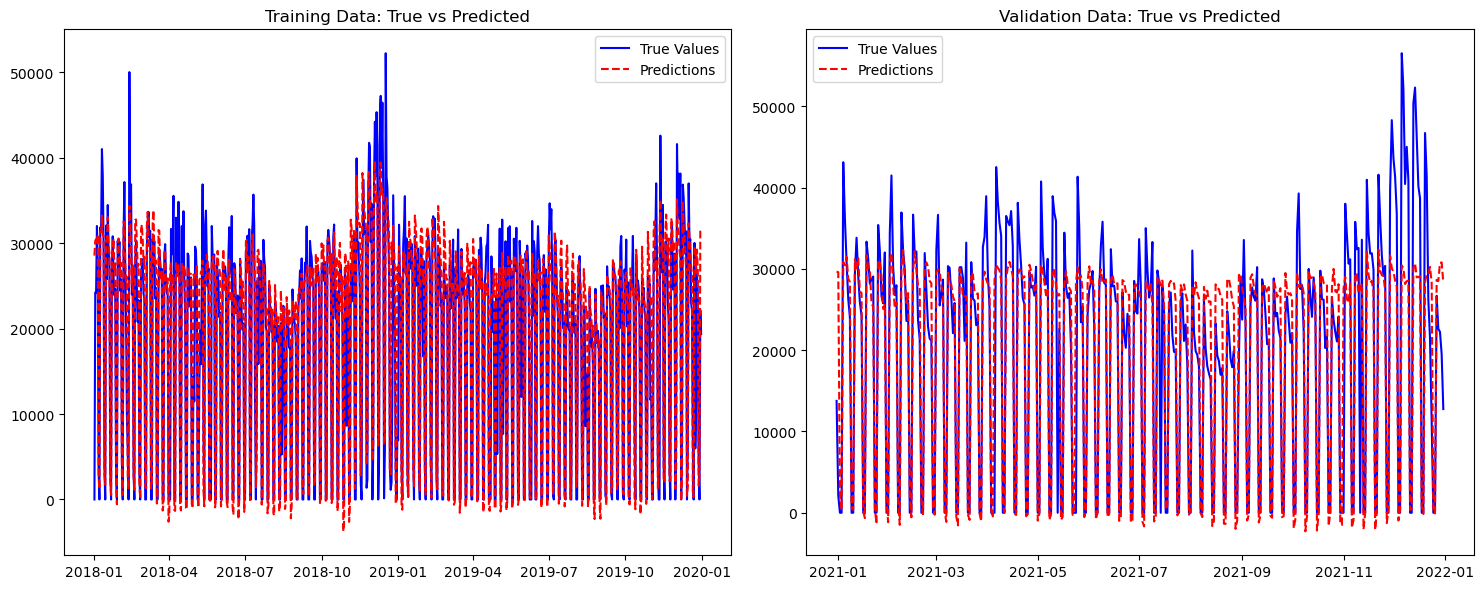

In [15]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)


# Predict on the training and validation data
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)


# Get the scaler for the target variable
target_scaler = scaler['tg1_traffic']

# Rescale predictions
y_train_pred_rescaled = target_scaler.inverse_transform(y_train_pred)
y_val_pred_rescaled = target_scaler.inverse_transform(y_val_pred)

# Rescale true values
y_train_rescaled = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))

import matplotlib.pyplot as plt

# Plot for training data
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(train_dates, y_train_rescaled, label='True Values', color='blue')
plt.plot(train_dates, y_train_pred_rescaled, label='Predictions', color='red', linestyle='--')
plt.title('Training Data: True vs Predicted')
plt.legend()

# Plot for validation data
plt.subplot(1, 2, 2)
plt.plot(val_dates, y_val_rescaled, label='True Values', color='blue')
plt.plot(val_dates, y_val_pred_rescaled, label='Predictions', color='red', linestyle='--')
plt.title('Validation Data: True vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()



In [16]:
def calculate_mape(y_true, y_pred):
    # Filter out the entries for which y_true is zero
    non_zero_mask = y_true != 0
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]
    
    # Calculate the MAPE
    mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    return mape
# Calculate MAPE for training data
mape_train = calculate_mape(y_train_rescaled.flatten(), y_train_pred_rescaled.flatten())

# Calculate MAPE for validation data
mape_val = calculate_mape(y_val_rescaled.flatten(), y_val_pred_rescaled.flatten())

print(f"MAPE on Training Data: {mape_train:.2f}%")
print(f"MAPE on Validation Data: {mape_val:.2f}%")


MAPE on Training Data: 37.05%
MAPE on Validation Data: 23.23%
